## RTK to XML visualization test
#### April Novak

This notebook illustrates how to 1) visualize an RTK geometry using raytracing and 2) visualize tally output with both h5py and the python tools developed by ORNL. To visualize, you need to input an input-name.shift.rtk.xml file, which is generated from the vera_to_shift executable. Simply using the react2xml script will not create the correct verion of the rtk.xml file that is to be used for raytracing. The XML file generated by the react2xml script is used as input for the vera_to_shift executable.

For visualizing the geometry with raytracing:

+ **2a.shift.rtk.xml** : XML representation of the RTK (VERA) geometry

For visualizing the fission source produced by VERA:

+ **2a.src-extracted.shift.h5** : modified fission source file generated by VERA

For visualizing the tallies:

+ **2a.out.h5** : Omnibus output file when all BCs in Omnibus are set to vacuum

For verification of the units for tallies:

+ **3a-diagnostic.out.h5** : Omnibus output file with a diagnostic tally

For completeness (documentation purposes) - not actually used for plotting:
+ **2a.inp**: original VERA input
+ **2a.omn**: Omnibus input (where tallies are defined)


In [1]:
import sys

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# path to Exnihilo-specific python modules on your machine. This is a path
# on a personal machine due to the mounting to orthanc.
sys.path.insert(0, '/Users/aprilnovak/Installs/python')
sys.path.append('/Users/aprilnovak/anaconda3/lib/python3.5/')

import exnihilotools.matplotlib as extools

extools.screen_style()
%matplotlib inline

In [2]:
# for plotting tallies
from omnibus.data import plot
from matplotlib.colors import Normalize, LogNorm

In [3]:
# for plotting geometry
from geometria import RTK_Geometry
from omnibus.raytrace.colors import ColorMap
from omnibus.raytrace.imager import Imager
from omnibus.raytrace.load import load_rtk

In [4]:
model = load_rtk('2a/2a.shift.rtk.xml')

In [5]:
# record description of the model
description = model.geometry.describe()

In [6]:
# Set parameters for the plots
tracer = 'cell'
color_map = 'CMRmap'

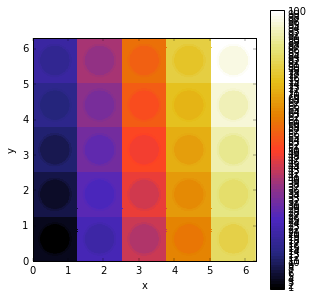

In [7]:
z = 0.5
x = 1.26*5
y = 1.26*5

# plot using a method where you can specify the lower left corner and the 
# upper right corner of the desired domain
imager = Imager(model.geometry, lower = (0.0, 0.0, z), upper = (x, y, z), \
                basis = (1, 0, 0), max_pixels=600)
imager.plot(figsize=(5.0, 5.0), cmap=cm.get_cmap(color_map));

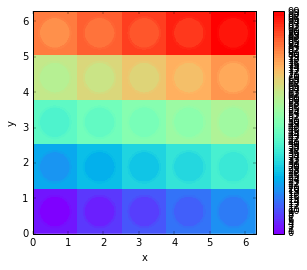

In [8]:
# plot a slice through the domain
imager = Imager.from_extents(model.geometry, z=0.5)
imager.trace = tracer
imager.plot();

## Tally and Fission Source Visualization

This section will demonstrate how to visualize the tallies that are defined in the Omnibus input. By default, all of the solution data remains on disk, so each time the raw data is sliced, an HDF5 read operation is performed. The .extract() method loads an entire field into memory, which can be advantageous if you're going to be performing repeated operations on that data.

### Some notes on tallies: 
Cell and mesh tallies produce volume-average quantities by default, if the volumes are available for the cells being tallied. The output units of these tallies is reactions/(cm^3 s). All tally output is given in the vera-input.out.h5 file. 

An energy filter (integration over energy) is applied automatically over all energies, unless neutron_bins and photon_bins (lists of energy intervals) are specified, in which case the tally output will be a function of that energy group structure specified. 

### Plot the fission source generated by VERA
The fission source produced by VERA can be plotted manually using h5py.

[[ 0.57757985  0.57711775  0.57682404  0.57711775  0.57757985]
 [ 0.57711775  0.57682404  0.57711775  0.57757985  0.57711775]
 [ 0.57682404  0.57711775  0.57757985  0.57711775  0.57731495]
 [ 0.57711775  0.57757985  0.57711775  0.57731495  0.57704967]
 [ 0.57757985  0.57711775  0.57731495  0.57704967  0.57731495]]


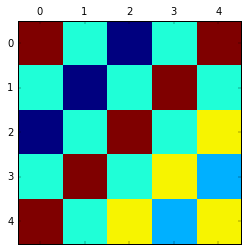

In [9]:
with h5.File("2a/2a.src-extracted.shift.h5") as f:
    source = f['strength']
    size = int(np.sqrt(source.shape[0]))
    source_matrix = np.empty((size, size))
    
    for i in range(size):
        for j in range(size):
            source_matrix[i][j] = source[i + j]
    
    print(source_matrix)
    plt.matshow(source_matrix)

### Vacuum BCs in Omnibus
The original VERA BCs are reflecting on all sides, but here the BCs are made vacuum in Omnibus. This plot of the fission reaction rate is generated with 100,000 particles.

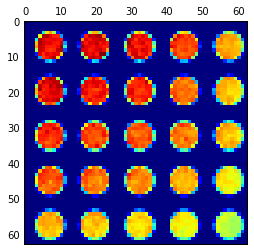

In [10]:
with h5.File("2a/2a.out.h5", 'r') as f:    
    mesh_tal = f['tally']['mesh_tally']
    mesh_total = mesh_tal['total']
    points = len(mesh_total[0])
    mesh_matrix = np.empty((points, points))
    
    for i in range(points):
        for j in range(points):
            # unknown if this is the correct orientation of the data
            mesh_matrix[i][j] = mesh_total[0][-i][-j][0][0]
    
    plt.matshow(mesh_matrix)

# Visualization with Omnibus Tools
The output file can also be visualized using the Omnibus tools. To do so, the version of python that is used by Omnibus had to be updated so that the load method of omnibus.formats.output would correctly read in the HDF5 output file.

The load().extract() method loads in all the information at once, which is useful if we are going to be performing many operations on the data. Information can be extracted from the HDF5 output file in either a dictionary-style way (parent['value']) or in a member style (parent.value). 

To plot data, the .xs method is useful because it allows you take slices through the domain. The fields under the "Axes" heading below show the values that can be specified in a call to .xs. 

In [11]:
from omnibus.formats.output import load

In [12]:
output = load("2a/2a.out.h5").extract();

Loading HDF5 file...
Loading Omnibus output from HDF5 data at 2a/2a.out.h5
INFO: Loaded 'Ex-core region for core from 2a_modified.inp': Omnibus output calculated on 2017JAN11 12:50
INFO: Data generated with Exnihilo version 6.2 (r29324: #3f9d5b56 on 2017JAN03) [debug] [DBC=7], Scale version 6.3 (r22294: #b59c8735 on 2017JAN03) [debug] [DBC=7]
            ...finished loading HDF5 file in 1.8 seconds
/Users/aprilnovak/Installs/python/omnibus/data/dataset.py:146: RuntimeWarning: Extracting compound dataset manually because this version of h5py does not properly support aligned data types
  "data types", RuntimeWarning)


In [13]:
tallies = output['tally']
mesh_tally = tallies.mesh_tally.total
mesh_tally

MeshTallyField(name='total', data=array([[[[[ 0... 0.,  0.]]]]]), axes=[CellDataAxis(...', 'mesh_z'))), CellDataAxis(...', 'mesh_y'))), CellDataAxis(...', 'mesh_x'))), MultiplierAxi...lier_names'))), LabelAxis(nam...'mesh_stat')))], hyperslice=[], location=Location(file...ly', 'total')))

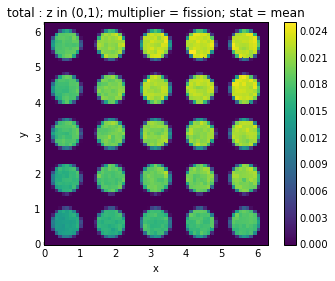

In [14]:
plot(mesh_tally.xs(z=0.9, stat='mean', multiplier='fission'));

## Verification of fission_source
This section uses a diagnostic tally to investigate whether or not the tallies have the correct units in the Omnibus inputs (or if some normalization factor should be applied). The results of this mesh tally should match the fission_source from VERA.

In [15]:
output = load("3a/3a-diagnostic.out.h5").extract();

Loading HDF5 file...
Loading Omnibus output from HDF5 data at 3a/3a-diagnostic.out.h5
INFO: Loaded 'case-3a.inp': Omnibus output calculated on 2017JAN17 10:58
INFO: Data generated with Exnihilo version 6.2 (r29324: #3f9d5b56 on 2017JAN03) [debug] [DBC=7], Scale version 6.3 (r22294: #b59c8735 on 2017JAN03) [debug] [DBC=7]
            ...finished loading HDF5 file in 1.5 seconds
/Users/aprilnovak/Installs/python/omnibus/data/dataset.py:146: RuntimeWarning: Extracting compound dataset manually because this version of h5py does not properly support aligned data types
  "data types", RuntimeWarning)


In [27]:
tallies = output['tally']
mesh_tally = tallies.source_diagnostic
print(mesh_tally)

Group(
 name     = 'source_diagnostic',
 data     = {},
 location = Location(filename='3a/3a-di ... ly', 'source_diagnostic')),
)


In [24]:
0.57757985/0.0248173

23.2732750943898

In [23]:
0.57711775/0.0249433

23.137185135888192

In [28]:
0.57682404/0.0280927

20.532880072047185